In [1]:
import pandas as pd
import pdb
import random
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, model_selection
from sklearn.metrics import mean_squared_error, r2_score
from numpy.random import multinomial
rowCols = ['Percent Black', 'Percent White', 'Percent Asian', 'Percent Hispanic']
rankCols = [col + ' Ranking' for col in rowCols] 
neededCols = [rowCols[:1][0], 'Average Score (SAT Math)']
df = pd.read_csv('scores.csv')
zip_to_boro = pd.read_csv('zip_borough.csv')
boros = ['Manhattan', 'Staten', 'Bronx', 'Queens', 'Brooklyn']
df.shape

(434, 22)

In [2]:
zip_to_boro.borough.unique()
boro_to_int = dict(zip(zip_to_boro.borough.unique(), [1,2,3,4,5]))
zip_to_boro['boro_id'] = zip_to_boro.borough.apply(lambda x: boro_to_int[x])
zip_to_boro = zip_to_boro.set_index('zip')
zip_to_boro.head(), boro_to_int


(         borough  boro_id
 zip                      
 10001  Manhattan        1
 10002  Manhattan        1
 10003  Manhattan        1
 10004  Manhattan        1
 10005  Manhattan        1,
 {'Manhattan': 1, 'Staten': 2, 'Bronx': 3, 'Queens': 4, 'Brooklyn': 5})

In [3]:
df['boro_id'] = df['Zip Code'].apply(lambda x: zip_to_boro.loc[x]['borough'])


In [4]:
for col in neededCols:
    df = df[pd.notnull(df[col])]
df.shape

(374, 23)

In [5]:
df = df.join(pd.get_dummies(df['boro_id']))

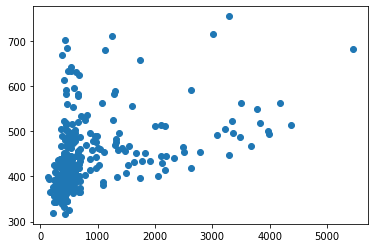

In [6]:
plt.scatter(df['Student Enrollment'], df['Average Score (SAT Math)'])

In [7]:
for col in rowCols:
    df[col] = pd.to_numeric(df[col].map(lambda pcnt: pcnt.strip('%')))

In [8]:
def getOther(row):
    return 100 - row[rowCols].sum()

df['Percent Other'] = df[rowCols].apply(getOther, axis=1)

In [9]:
df.columns

Index(['School ID', 'School Name', 'Borough', 'Building Code',
       'Street Address', 'City', 'State', 'Zip Code', 'Latitude', 'Longitude',
       'Phone Number', 'Start Time', 'End Time', 'Student Enrollment',
       'Percent White', 'Percent Black', 'Percent Hispanic', 'Percent Asian',
       'Average Score (SAT Math)', 'Average Score (SAT Reading)',
       'Average Score (SAT Writing)', 'Percent Tested', 'boro_id', 'Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten', 'Percent Other'],
      dtype='object')

In [10]:
# for col in rowCols:
#     df[col + ' Ranking'] = 0

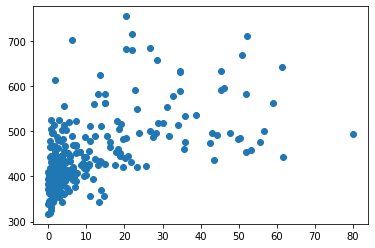

In [11]:
plt.scatter(df['Percent White'], df['Average Score (SAT Math)'])

In [12]:
df.head()

,School ID,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,...,Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested,boro_id,Bronx,Brooklyn,Manhattan,Queens,Staten,Percent Other
2,01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,...,601.0,601.0,91.00%,Manhattan,0,0,1,0,0,1.6
3,02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,411.0,387.0,78.90%,Manhattan,0,0,1,0,0,2.6
4,02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,428.0,415.0,65.10%,Manhattan,0,0,1,0,0,3.2
5,02M545,High School for Dual Language and Asian Studies,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,453.0,463.0,95.90%,Manhattan,0,0,1,0,0,0.8
6,01M292,Henry Street School for International Studies,Manhattan,M056,220 Henry Street,Manhattan,NY,10002,40.71376,-73.98526,...,406.0,381.0,59.70%,Manhattan,0,0,1,0,0,1.9


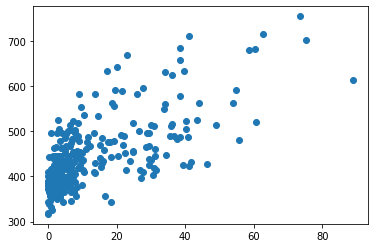

In [13]:
plt.scatter(df['Percent Asian'], df['Average Score (SAT Math)'])

In [70]:
def randomizeDemos(row):
    try:
        new_demos = multinomial(100, row[rowCols + ['Percent Other']].values * 0.01)
        obj = dict(zip(rowCols + ['Percent Other'], new_demos))
        obj['Average Score (SAT Math)'] = row['Average Score (SAT Math)']  * random.uniform(.9, 1.1)
        for b in boros:
            obj[b] = row[b]
    except:
        return
        
    return pd.Series(obj)

simulated_schools = pd.concat([df[rowCols + ['Percent Other', 'Average Score (SAT Math)'] + boros].apply(randomizeDemos, axis=1) for _ in range(20)])
simulated_schools.head()

,Percent Black,Percent White,Percent Asian,Percent Hispanic,Percent Other,Average Score (SAT Math),Manhattan,Staten,Bronx,Queens,Brooklyn
2,12.0,28.0,40.0,17.0,3.0,665.850087,1.0,0.0,0.0,0.0,0.0
3,43.0,15.0,6.0,35.0,1.0,362.778211,1.0,0.0,0.0,0.0,0.0
4,27.0,2.0,10.0,60.0,1.0,386.030616,1.0,0.0,0.0,0.0,0.0
5,2.0,1.0,92.0,3.0,2.0,558.364524,1.0,0.0,0.0,0.0,0.0
6,24.0,6.0,10.0,59.0,1.0,419.253712,1.0,0.0,0.0,0.0,0.0


In [94]:
simulated_schools['Black Variance'] = simulated_schools['Percent Black'] / simulated_schools['Percent Black'].mean()

In [95]:
df['Black Variance'] = df['Percent Black'] / df['Percent Black'].mean()

In [96]:
simulated_schools = simulated_schools.dropna()

In [97]:
df[rowCols + ['Percent Other', 'Average Score (SAT Math)'] + boros + ['Black Variance']].head()

,Percent Black,Percent White,Percent Asian,Percent Hispanic,Percent Other,Average Score (SAT Math),Manhattan,Staten,Bronx,Queens,Brooklyn,Black Variance
2,13.3,28.6,38.5,18.0,1.6,657.0,1,0,0,0,0,0.376386
3,38.5,11.7,5.9,41.3,2.6,395.0,1,0,0,0,0,1.089537
4,28.2,3.1,8.6,56.9,3.2,418.0,1,0,0,0,0,0.798051
5,3.1,1.7,88.9,5.5,0.8,613.0,1,0,0,0,0,0.087729
6,24.4,3.9,13.2,56.6,1.9,410.0,1,0,0,0,0,0.690512


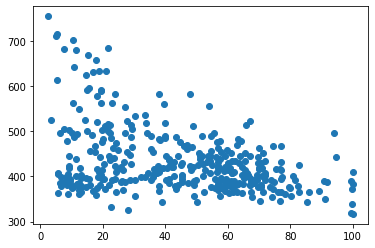

In [73]:
plt.scatter(df['Percent Hispanic'], df['Average Score (SAT Math)'])

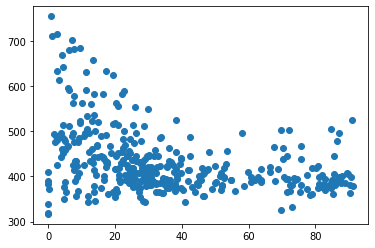

In [74]:
plt.scatter(df['Percent Black'], df['Average Score (SAT Math)'])

In [98]:
x_train = simulated_schools[rowCols + ['Percent Other'] + boros + ['Black Variance']]
x_test = df[rowCols + ['Percent Other'] + boros + ['Black Variance']]

y_train = simulated_schools['Average Score (SAT Math)']
y_test = df['Average Score (SAT Math)']

In [99]:
#x_train, x_test, y_train, y_test = model_selection.train_test_split(df[rowCols + ['Percent Other']], df['Average Score (SAT Math)'])

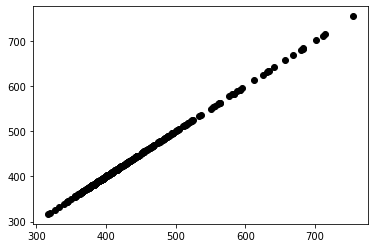

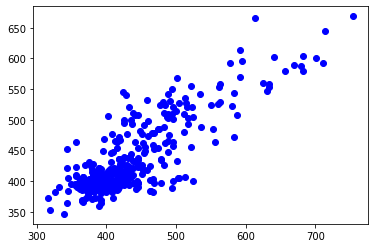

In [100]:
# create a linear regression object
regr = linear_model.LinearRegression()

# train the model using the training sets
regr.fit(x_train, y_train)

# make predicitons using the testing set
y_predictions = regr.predict(x_test)

plt.scatter(y_test, y_test, color="black")
plt.xticks()
plt.yticks()

plt.show()

plt.scatter(y_test, y_predictions, color="blue")
plt.show()

In [101]:
# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error: %.2f"
     % mean_squared_error(y_test, y_predictions))

# Explained variance score: 1 is the perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_predictions))

Coefficients: 
 [ -1.5261081    0.510298     1.25511511  -1.85495271   1.61564771
  23.94859742 -19.18494385  13.70218109 -12.55781973  -5.90801493
  -0.04334098]
Mean squared error: 1558.43
Variance score: 0.70
